<a href="https://colab.research.google.com/github/nakanoelio/i2a2-challenge-petr4-trad-sys/blob/main/I2A2_PETR4_Naive_Bayes_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
!pip install yfinance
!pip install --upgrade mplfinance

#Instalação da Biblioteca TA-lib
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Requirement already up-to-date: mplfinance in /usr/local/lib/python3.7/dist-packages (0.12.7a17)
(Reading database ... 160798 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [150]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sn
import matplotlib.pyplot as plt

import yfinance as yf

import talib as ta

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

In [151]:
%matplotlib inline

In [152]:
stock_ticker = 'PETR4.SA'
start_date = '2015-11-30'
end_date = '2021-5-27'

yf_petr4 = yf.Ticker(stock_ticker)
df_petr4 = yf_petr4.history(start=start_date, end=end_date)

stock_ticker = '^BVSP'
yf_ibov = yf.Ticker(stock_ticker)
df_ibov = yf_ibov.history(start=start_date, end=end_date)

In [153]:
df_petr4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1360 entries, 2015-11-30 to 2021-05-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1360 non-null   float64
 1   High          1360 non-null   float64
 2   Low           1360 non-null   float64
 3   Close         1360 non-null   float64
 4   Volume        1360 non-null   int64  
 5   Dividends     1360 non-null   float64
 6   Stock Splits  1360 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 85.0 KB


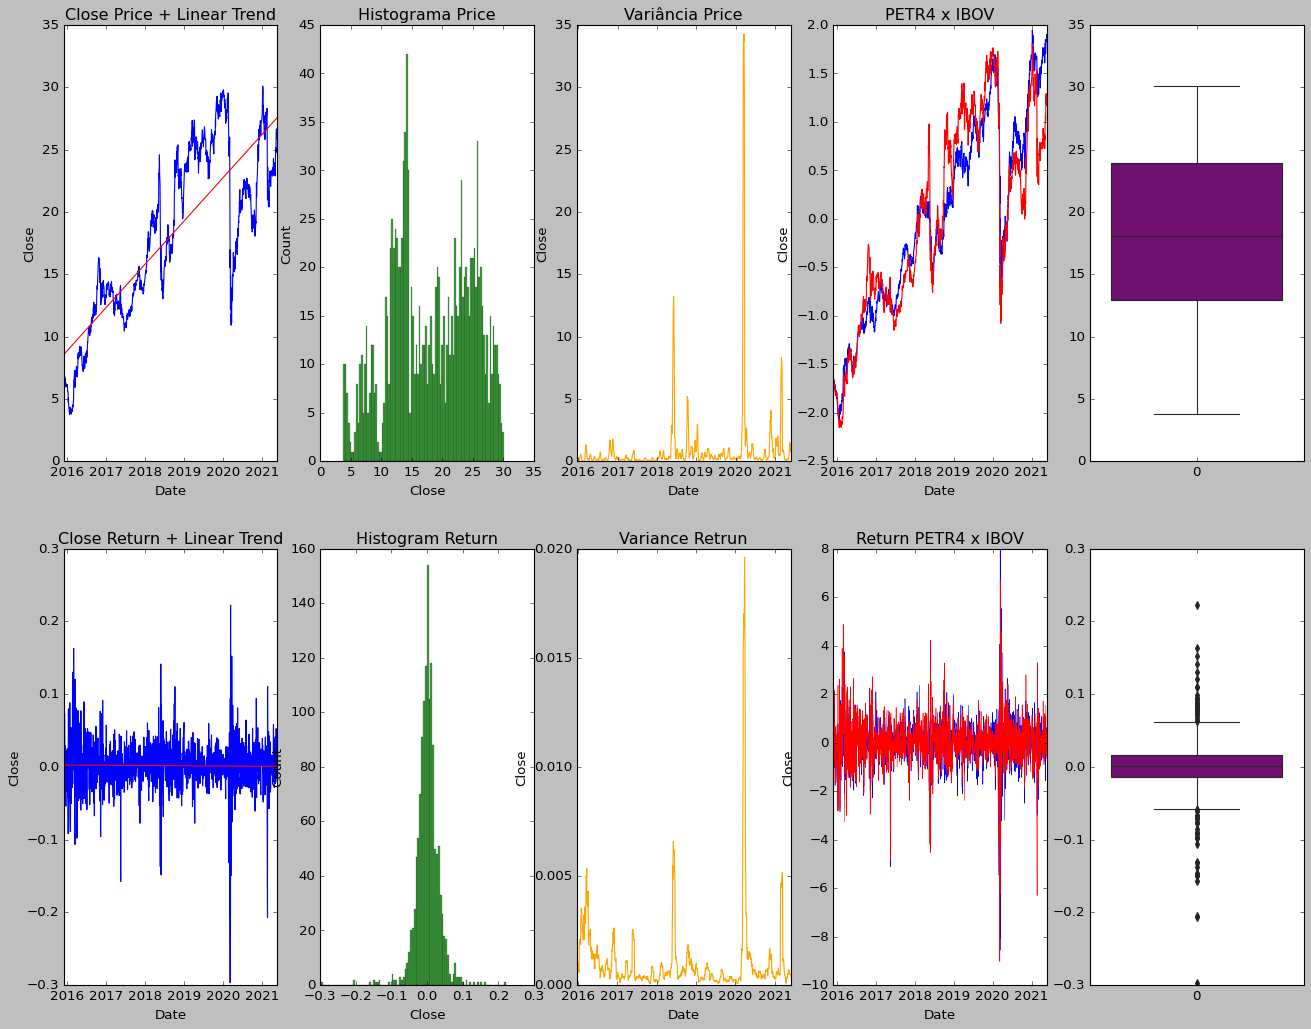

In [154]:

plt.style.use('classic')
fig, ax = plt.subplots(2,5,figsize=(20,15))

ax[0,0].set_title("Close Price + Linear Trend")
ax[0,1].set_title("Histograma Price")
ax[0,2].set_title("Variância Price")
ax[0,3].set_title("PETR4 x IBOV")

ax[1,0].set_title("Close Return + Linear Trend")
ax[1,1].set_title("Histogram Return")
ax[1,2].set_title("Variance Retrun")
ax[1,3].set_title("Return PETR4 x IBOV")

def regress(y_data):

    y = y_data
    x = np.linspace(1, len(y), num=len(y))
    coef = np.polyfit(x, y, deg=1, rcond=None, full=False, w=None, cov=False)

    return [np.poly1d(coef)(i) for i in x]

x_reg = [df_petr4["Close"].head(1).index.item(),df_petr4["Close"].tail(1).index.item()]
y_reg = [regress(df_petr4["Close"])[0],regress(df_petr4["Close"])[-1]]

sn.lineplot(data=df_petr4["Close"],ax=ax[0,0])
sn.lineplot(x=x_reg, y=y_reg,ax=ax[0,0],color="red")
sn.histplot(data=df_petr4["Close"],bins=100,ax=ax[0,1],color="green")
sn.lineplot(data=df_petr4["Close"].rolling(15).var(),ax=ax[0,2],color="orange")
sn.lineplot(data=(df_ibov["Close"]-df_ibov["Close"].mean())/df_ibov["Close"].std(),ax=ax[0,3])
sn.lineplot(data=(df_petr4["Close"]-df_petr4["Close"].mean())/df_petr4["Close"].std(),ax=ax[0,3],color="red")
sn.boxplot(data=df_petr4["Close"],ax=ax[0,4],color="purple")

x_reg_rt = [df_petr4["Close"].pct_change().head(1).index.item(),df_petr4["Close"].pct_change().tail(1).index.item()]
y_reg_rt = [regress(df_petr4["Close"].pct_change().dropna())[0],regress(df_petr4["Close"].pct_change().dropna())[-1]]

sn.lineplot(data=df_petr4["Close"].pct_change(),ax=ax[1,0],color="blue")
sn.lineplot(x=x_reg_rt, y=y_reg_rt,ax=ax[1,0],color="red")
sn.histplot(data=df_petr4["Close"].pct_change(),bins=100,ax=ax[1,1],color="green")
sn.lineplot(data=df_petr4["Close"].pct_change().rolling(15).var(),ax=ax[1,2],color="orange")
sn.lineplot(data=(df_ibov["Close"].pct_change()-df_ibov["Close"].pct_change().mean())/df_ibov["Close"].pct_change().std(),ax=ax[1,3],lw=.5)
sn.lineplot(data=(df_petr4["Close"].pct_change()-df_petr4["Close"].pct_change().mean())/df_petr4["Close"].pct_change().std(),ax=ax[1,3],color="red",lw=.5)
sn.boxplot(data=df_petr4["Close"].pct_change(),ax=ax[1,4],color="purple")

#df_petr4["Close"].pct_change().plot(kind="box",ax=ax[1,3])
#sn.histplot(data=df_petr4["Close"].pct_change().rolling(5).var(),bins=100,ax=ax[1,3],color="green")


In [155]:
df_ibov["Close"].pct_change().describe()

count    1353.000000
mean        0.000900
std         0.017359
min        -0.147797
25%        -0.007222
50%         0.001110
75%         0.009842
max         0.139082
Name: Close, dtype: float64

In [156]:
df_petr4["Close"].pct_change().describe()

count    1359.000000
mean        0.001539
std         0.033059
min        -0.296978
25%        -0.013350
50%         0.001276
75%         0.016689
max         0.222222
Name: Close, dtype: float64

In [157]:
df_petr4

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-11-30,6.767124,7.036373,6.659424,6.883799,72764300,0.0,0
2015-12-01,6.883799,6.964574,6.686350,6.722250,35865600,0.0,0
2015-12-02,6.767124,6.811999,6.596599,6.749174,47713500,0.0,0
2015-12-03,7.170996,7.332546,6.991497,7.162022,76680900,0.0,0
2015-12-04,7.153047,7.153047,6.659424,6.749174,63662600,0.0,0
...,...,...,...,...,...,...,...
2021-05-20,26.150000,26.280001,25.719999,25.930000,71371100,0.0,0
2021-05-21,26.080000,26.309999,25.940001,25.950001,82884500,0.0,0
2021-05-24,26.280001,26.520000,25.990000,26.389999,63029600,0.0,0


In [158]:
#Calculo dos Indicadores
def indicadores(stock_data):
    
    data = stock_data.copy()
    data['W%R'] = ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14) #Retorna valor do indicador Williams %R
    data['MACD'], data['Signal-line'], data['Histograma_MACD'] = ta.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9) #Valores do indicador MACD
    data.loc[:, 'Momento_MACD']=np.where(data['Histograma_MACD']>0, 1, 0) #Retorna 1 para compra pelo MACD (momento positivo), 0 para venda
    data['Tendencia_MACD']=np.where(data['Histograma_MACD'].diff()>0, 1, 0) #Derivada, sinaliza reversao de tendencia no histograma MACD, 1 para compra, 0 para venda
    data.loc[:, 'W%R_Compra']= np.where(data['W%R']<-80, 1, 0) # Retorna 1 para sinal de compra, caso Williams %R < -80
    data.loc[:, 'W%R_Venda']= np.where(data['W%R']>-20, 1, 0)  # Retorna 1 para sinal de venda, caso Williams %R > -20

    return data.drop(["Open","Close","High","Low","Volume","Dividends","Stock Splits"],axis="columns")

In [159]:
def isSupport(df,i):
    #Estamos utilizando dados futuros!
    #support = df['Low'][i] <= df['Low'][i-1]  and df['Low'][i] <= df['Low'][i+1] and df['Low'][i] < df['Low'][i+2] and df['Low'][i] < df['Low'][i-2]
    support = df['Low'][i-1] <= df['Low'][i-3]  and df['Low'][i-2] <= df['Low'][i-1] and df['Low'][i-2] < df['Low'][i] and df['Low'][i-2] < df['Low'][i-4]
    
    return support

def isResistance(df,i):
    #Estamos utilizando dados futuros!
    #resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] and df['High'][i] > df['High'][i+2] and df['High'][i] > df['High'][i-2]
    resistance = df['High'][i-2] > df['High'][i-3]  and df['High'][i-2] > df['High'][i-1] and df['High'][i-2] > df['High'][i] and df['High'][i-2] > df['High'][i-4]
    return resistance 

In [160]:
def isFarFromLevel(l,levels,s):

   return np.sum([abs(l-x) < s  for x in levels]) == 0

In [161]:
def sup_res(df_data):
    s =  np.mean(df_data['High'] - df_data['Low'])
    levels = []
    support = [0,0]
    resistance = [0,0]
    for i in range(2,df_data.shape[0]-2):
        if isSupport(df_data,i):
            l = df_data['Low'][i]
            support.append(1)
            resistance.append(0)
            levels.append((i,l))
            #if isFarFromLevel(l,levels,s):
                #support.append(1)
                #resistance.append(0)
                #levels.append((i,l))
            #else:
                #support.append(0)
                #resistance.append(0)
        elif isResistance(df_data,i):
            l = df_data['High'][i]
            support.append(0)
            resistance.append(1)
            #if isFarFromLevel(l,levels,s):
                #resistance.append(1)
                #support.append(0)
                #levels.append((i,l))
            #else:
                #resistance.append(0)
                #support.append(0)
        else:
            resistance.append(0)
            support.append(0)
    support.extend([0,0])
    resistance.extend([0,0])

    return support, resistance

In [162]:
def feat_gen(data_f, p_window,return_period):
    
    data_frame = data_f.copy()

    #data_frame["Close_Return"] = data_frame["Close"].diff()
    data_frame["Close_Return_Rel"] = data_frame["Close"].pct_change()
    
    #data_frame["Close_Return"].fillna(0,inplace=True)
    #data_frame["Close_Return_Rel"].fillna(0,inplace=True)
    tresh =  0
    #data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() > tresh, f"Expected_Close_Return_{return_period}"] = 3
    #data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() <= tresh, f"Expected_Close_Return_{return_period}"] = 2
    #data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() < -tresh, f"Expected_Close_Return_{return_period}"] = 1
    data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() >= tresh, f"Expected_Close_Return"] = 1
    data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() < tresh, f"Expected_Close_Return"] = 0
   
    new_col_names = []
 
    for i in range(1,p_window+1):
        data_frame[f'Return_Lag_{i}period'] = data_frame["Close_Return_Rel"].shift(periods=i)
   
    data_frame[f"Expected_Close_Return"] = data_frame[f"Expected_Close_Return"].shift(-1)

    return data_frame.drop(["Open","Close","High","Low","Volume","Dividends","Stock Splits"],axis="columns")


In [163]:
def calc_beta(data_frame_asset,data_frame_bench, beta_window):
    data_frame_beta = pd.concat([data_frame_bench["Close"].pct_change(), data_frame_asset["Close"].pct_change()],axis=1,ignore_index=True)

    data_frame_beta.columns=["Close_IBOV","Close_PETR4"]

    data_frame_beta["Beta"] = data_frame_beta["Close_PETR4"].rolling(beta_window).cov(data_frame_beta["Close_IBOV"].rolling(beta_window))/data_frame_beta["Close_IBOV"].rolling(beta_window).var()

    data_frame_beta["Beta_expected_PETR4"] = data_frame_beta["Close_IBOV"]*data_frame_beta["Beta"]

    data_frame_beta["PETR4_Excess_Variat"] = (data_frame_beta["Close_PETR4"] - data_frame_beta["Beta_expected_PETR4"])/data_frame_beta["Beta_expected_PETR4"]
    data_frame_beta["PETR4_Excess_Variat"].describe()
    var_tolerance = 1#data_frame_beta["Close_IBOV"].std()#/data_frame_beta["Close_IBOV"].mean()

    data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"]  > var_tolerance, "PETR4_Excess_Variat_Disc_pos"] = 1
    data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"] <= var_tolerance , "PETR4_Excess_Variat_Disc"] = 0
    
    data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"]  < -var_tolerance, "PETR4_Excess_Variat_Disc_neg"] = 1

    return data_frame_beta.drop(["Close_IBOV","Close_PETR4",], axis="columns").fillna(0)
    data_frame_beta.info()
    #return data_frame_beta["PETR4_Excess_Variat"].fillna(0)

In [164]:
def gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window):

    #df_feat = data_frame_orig
    df_feat = pd.concat([data_frame_orig, feat_gen(data_frame_orig, p_window, return_period)],axis=1)
    df_feat = pd.concat([df_feat,indicadores(data_frame_orig)],axis=1)
    sup,res = sup_res(data_frame_orig)
    df_feat["Support"] = sup
    df_feat["Resistance"] = res
    df_feat = pd.concat([df_feat,calc_beta(data_frame_orig,data_frame_bench,beta_window)],axis=1)
    df_feat = df_feat.reindex(columns=(list([col for col in df_feat.columns if col != "Expected_Close_Return"]+["Expected_Close_Return"])))
    df_feat = df_feat.drop(["Stock Splits","Dividends","Volume"],axis=1)

    return df_feat

In [165]:
#df_petr4_ind.tail(5)

In [166]:
#df_petr4_ind.columns

In [167]:
#fig,ax = plt.subplots(1,figsize=(20,20))
#fig.patch.set_facecolor('xkcd:white')
#ax = sn.heatmap(df_petr4_ind.corr(),linewidths=.5,annot=True,cmap="YlGnBu",cbar=False,square=True)

In [168]:
#df_petr4_ind.desc#ibe()

In [169]:
#g = sn.PairGrid(df_petr4_ind)
#g.map(sn.scatterplot)

In [170]:
#((df_petr4_ind["Close_Return_Rel"]-df_petr4_ind["Close_Return_Rel"].mean())/df_petr4_ind["Close_Return_Rel"].std()).describe()

In [171]:
data_frame_orig = df_petr4
p_window = 2
return_period = 3
beta_window = 30
data_frame_bench = df_ibov
df_petr4_ind = gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window)
df_petr4_ind = df_petr4_ind.drop(['Open', 'High', 'Low', 'Close', 'Close_Return_Rel','Return_Lag_1period', 'Return_Lag_2period', 
       'W%R', 'MACD','Signal-line', 'Histograma_MACD',  'Beta','Beta_expected_PETR4', 'PETR4_Excess_Variat'],axis="columns")

In [172]:
df_petr4_ind.head(30)

,Momento_MACD,Tendencia_MACD,W%R_Compra,W%R_Venda,Support,Resistance,PETR4_Excess_Variat_Disc,Expected_Close_Return
Date,,,,,,,,
2015-11-30,0,0,0,0,0,0,0.0,NaN
2015-12-01,0,0,0,0,0,0,0.0,NaN
2015-12-02,0,0,0,0,0,0,0.0,1.0
2015-12-03,0,0,0,0,0,0,0.0,1.0
2015-12-04,0,0,0,0,0,0,0.0,0.0
2015-12-07,0,0,0,0,0,1,0.0,0.0
2015-12-08,0,0,0,0,0,0,0.0,1.0
2015-12-09,0,0,0,0,0,0,0.0,1.0
2015-12-10,0,0,0,0,0,0,0.0,1.0


In [173]:
dia_ini_train_idx = df_petr4_ind.index.get_loc("2016-01-26 00:00:00")
dia_fin_train_idx = df_petr4_ind.index.get_loc("2018-01-26 00:00:00")
y_label_idx = df_petr4_ind.columns.get_loc("Expected_Close_Return")

In [174]:
X = df_petr4_ind.iloc[dia_ini_train_idx:dia_fin_train_idx-100].drop('Expected_Close_Return',axis='columns')
X_test = df_petr4_ind.iloc[dia_fin_train_idx-100:dia_fin_train_idx].drop('Expected_Close_Return',axis='columns')
y = df_petr4_ind.iloc[dia_ini_train_idx:dia_fin_train_idx-100,y_label_idx]
y_test = df_petr4_ind.iloc[dia_fin_train_idx-100:dia_fin_train_idx,y_label_idx]

In [175]:
def run_model(X,y,X_test,y_test,model_type):

    nb_model = model_type
    nb_model.fit(X, y)

    y_pred = nb_model.predict(X_test)
    print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
    print("Accuracy: %f"% metrics.balanced_accuracy_score(y_test, y_pred))
    #print("Precision: %d"% metrics.precision_score(y_test,y_pred))
    cf_train2 = metrics.confusion_matrix(y_test, y_pred, normalize="all")                                  
    sn.heatmap(cf_train2,linewidths=.5,annot=True,cmap="YlGnBu",cbar=False,square=True,xticklabels=(1,2,3), yticklabels=(1,2,3))
    
    return nb_model

Number of mislabeled points out of a total 100 points : 29
Accuracy: 0.673385


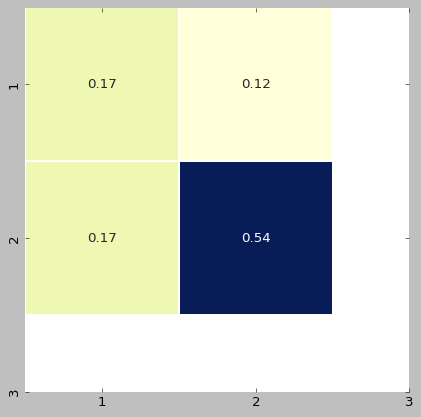

In [176]:
gnb = run_model(X,y,X_test,y_test,GaussianNB())

Number of mislabeled points out of a total 100 points : 29
Accuracy: 0.673385


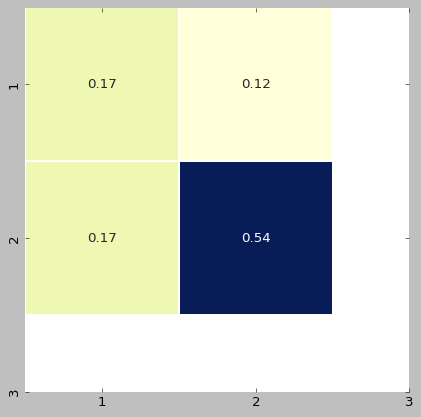

In [177]:
bnb = run_model(X,y,X_test,y_test,BernoulliNB())

In [178]:
print(np.column_stack((y_test.to_list(),bnb.predict(X_test),)))
print(bnb.predict_proba(X_test))
print(bnb.score(X_test,y_test))

[[1. 1.]
 [0. 0.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.03840028 0.96159972]
 [0.62024557 0.37975443]
 [0.03840028 0.96159972]
 [0.23673094 0.76326906]

Number of mislabeled points out of a total 100 points : 30
Accuracy: 0.635746


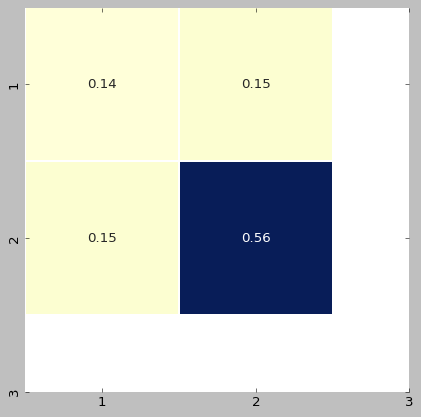

In [179]:
comnb = run_model(X,y,X_test,y_test,ComplementNB())

Number of mislabeled points out of a total 100 points : 29
Accuracy: 0.673385


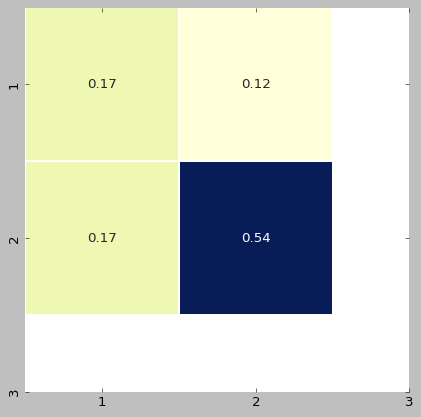

In [180]:
catnb = run_model(X,y,X_test,y_test,CategoricalNB())